그래프 그리기
======
### 타겟 설정
* 여기에서 설정한 타겟은 기본적으로 아래 코드에 모두 적용된다. 만약 각 부분에서 타겟을 변경하고 싶으면 함수의 인자로 target_으로 시작하는 변수 대신 커스텀 타겟을 입력하면 된다.

In [2]:
import os
from funs import *

# config 파일 경로 지정
config_dir = '../' 
config_path = os.path.join(config_dir, 'process_and_extract_config.yaml')
config = load_yaml(config_path)

# 타겟 설정
base_dir = '../output/1105/'
target_view = 'F'
target_RPM = 1200
target_fault_type = 'H'
target_axis = 'z'
target_marker = 'A'

### 1. 원본 변위 플롯
* x_len을 숫자로 설정하면 처음부터 해당 숫자까지의 데이터만 표시한다. 모든 시간에 해당하는 데이터를 보고 싶으면 None을 입력한다.
* get_dir_list에서는 타겟으로 원하는 view(F, S), fault_type(H, IR, OR, B, M, U, L), RPM(600, 1200, 1400)을 지정할 수 있다. 만약 인자를 입력하지 않는다면 모든 데이터를 플롯한다.
* draw_single_graphs에서는 타겟으로 원하는 axis(x, y, z)를 설정할 수 있다. axis는 리스트 형태(e.g. ['x.csv', 'z.csv'])로 입력해야 한다.

['../output/1105/1105_6204_1200_H_F']
['x.csv', 'z.csv', 'r.csv']


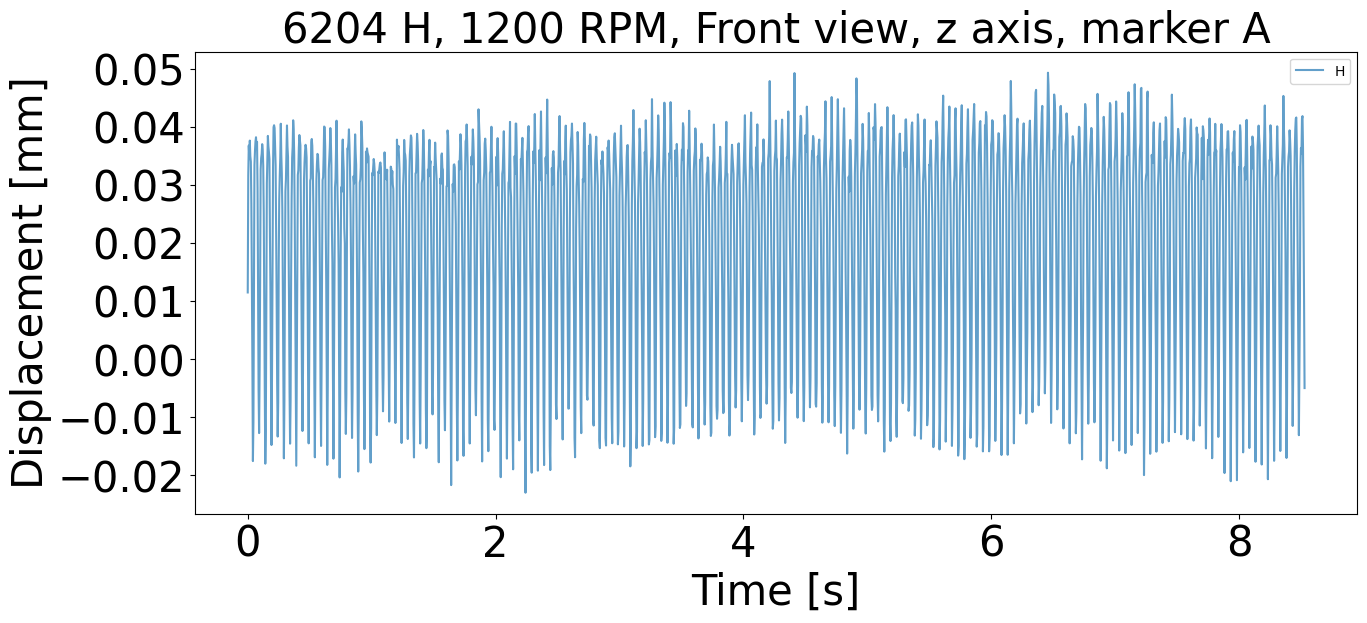

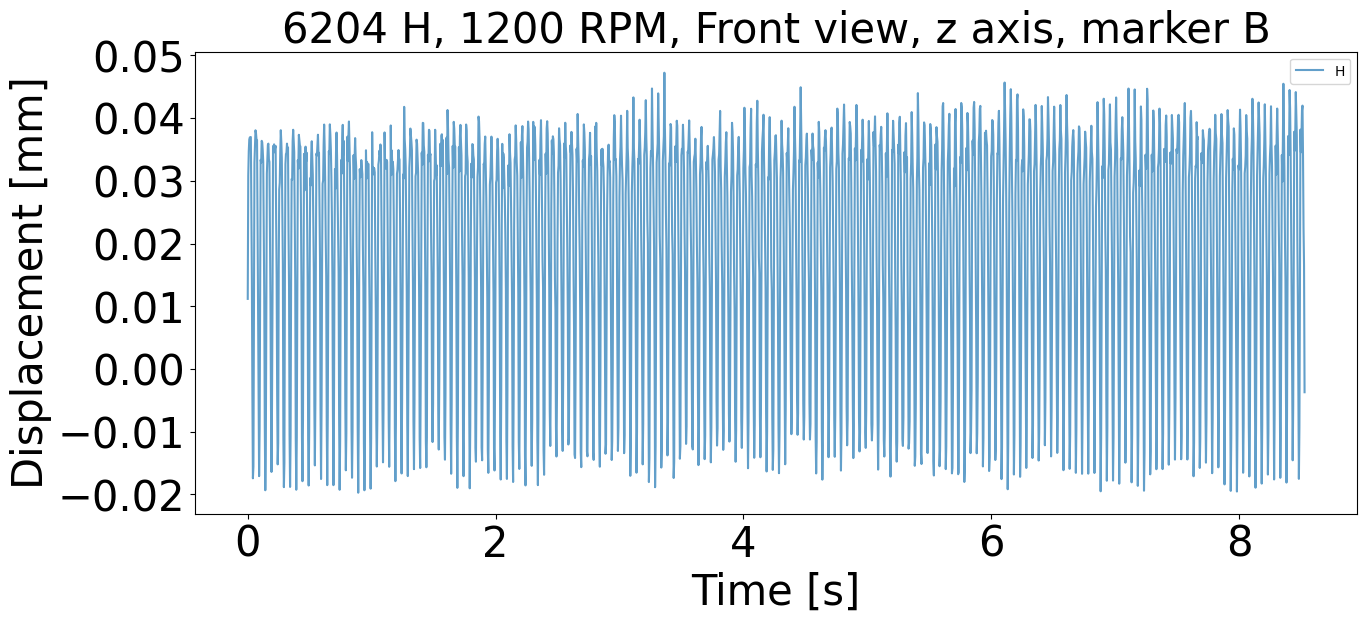

In [2]:
# 뒷부분 자를 경우 숫자 설정, 전체 보고 싶으면 None
x_len = 2048

dir_list = get_dir_list(base_dir, target_view=target_view, target_fault_type=target_fault_type, target_rpm=target_RPM)
print(dir_list)
draw_single_graphs(dir_list, target_csv_list=['z.csv'], length = x_len)

### 주파수 설정
* 주파수 분석에 필요한 설정을 변경할 수 있다. 기본적으로는 변경할 것이 없다.
    - fps: 영상의 프레임 (기본 240)
    - x_len: 원본 데이터에서 처음부터 x_len까지의 데이터만 분석 대상으로 한다. 데이터를 자르고 싶지 않을 때는 데이터의 길이보다 숫자를 크게 설정하면 된다.
    - bandpass filter: 원하는 대역의 frequency 성분만 남김.
    - conversion_factors: mm/px 변환값으로, process_and_extract_config.yaml에 저장됨.
    - fault_frequencies: 각 베어링 별 BPFI, BPFO, BSF 배수

In [3]:
# Import necessary libraries
from scipy.signal import butter, filtfilt, hilbert
from tabulate import tabulate
from matplotlib import cycler

# Sampling frequency
fps = 240

# 뒷부분 자르기, 안 자르고 싶을 때는 숫자를 넉넉하게 설정
x_len = 240 * 60 * 10

# Design bandpass filter
lowcut = 1.0
highcut = 119.0
nyquist = 0.5 * fps
low = lowcut / nyquist
high = highcut / nyquist
b, a = butter(4, [low, high], btype='band')

# Conversion factors for different views and axes
conversion_factors = config.conversion_factors

# Fault frequencies for different bearing types and fault types
fault_frequencies = {
    '6204': {'IR': 4.92, 'OR': 3.08, 'B': 2.06},
    '30204': {'IR': 8.8, 'OR': 6.2, 'B': 2.8},
    'default': {'IR': 6.71, 'OR': 4.29, 'B': 2.16}
}

### 2. FFT 및 Envelope 그래프 그리기
* base_dir 디렉토리에서 리스트 ['x.csv', 'y.csv', 'z.csv', 'r.csv'] 에 해당하는 파일의 모든 경로를 file_paths에 저장한다. base_dir은 기본적으로 맨 위의 타겟 설정에서 지정되었고, 이곳에서 변경이 가능하다.
* process_and_plot 함수는 지정된 file_paths에서 타겟에 해당하는 데이터에 대해 FFT와 Envelope를 그린다. 함수의 인자를 변경하여 위에서 설정한 타겟과 다른 타겟을 설정할 수 있다.

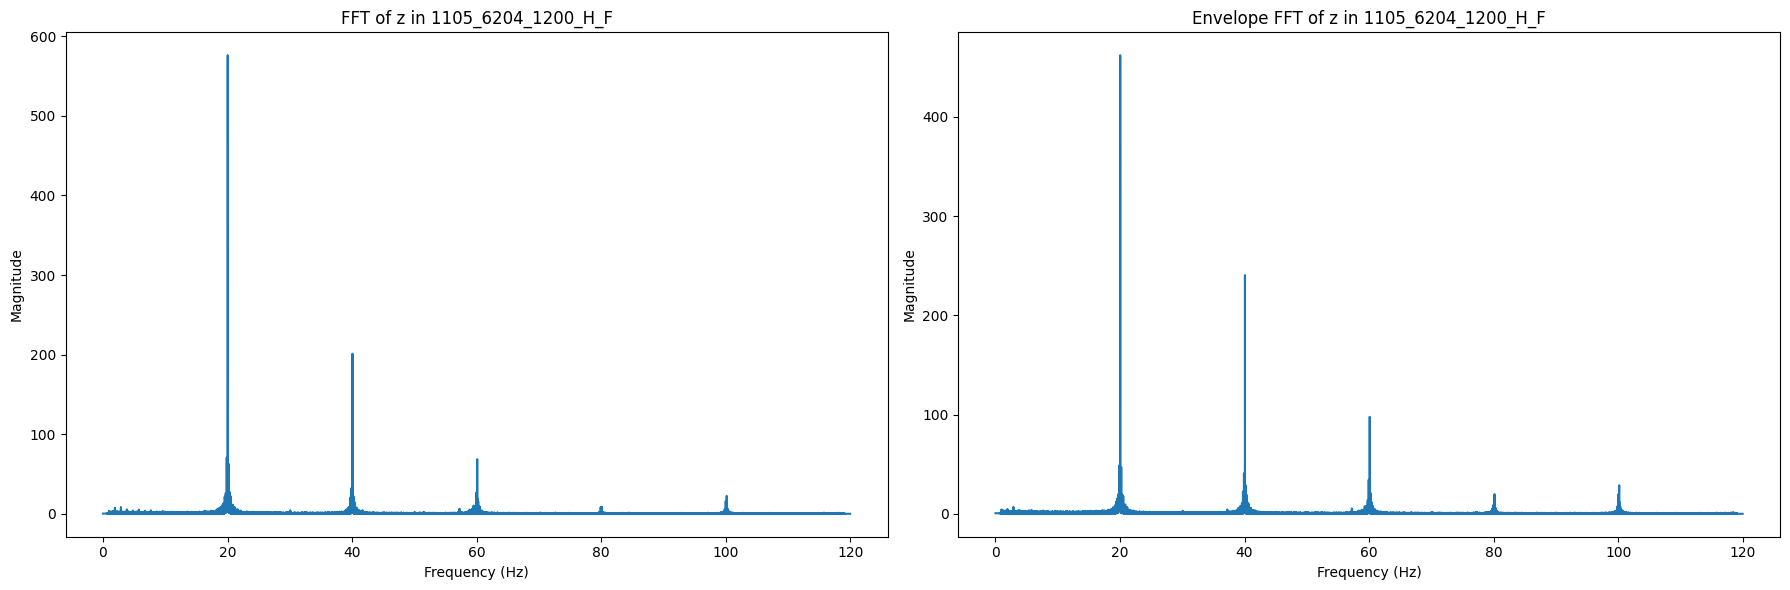

In [ ]:
def process_and_plot(file_paths, dir_name, target_axis=None, target_fault_type=None, target_marker=None, target_RPM=None, target_view=None):
    data = {}
    parts = dir_name.split('_')
    date = parts[0]
    view = parts[-1]
    fault_type = parts[-2]
    RPM = int(parts[-3])
    bearing_type = parts[-4]

    # Check if the current directory matches the target criteria
    if (target_view and view != target_view
        ) or (target_RPM and RPM != target_RPM
              ) or (target_fault_type and fault_type != target_fault_type):
        return

    # Determine the conversion factor
    if int(date) < 1100:
        conversion_factor = conversion_factors.get(date, {}).get(view, 1)
    elif int(date) == 1105:
        conversion_factor = conversion_factors.get(date, {}).get(view, 1).get(fault_type, 1)
    else:
        conversion_factor = conversion_factors.get(date, {}).get(view, 1).get(target_marker, 1)

    for axis, file_path in file_paths.items():
        if target_axis and axis != target_axis:
            continue
        if target_marker == 'A':
            values = pd.read_csv(file_path).iloc[:x_len, 0].values
        if target_marker == 'B':
            values = pd.read_csv(file_path).iloc[:x_len, 1].values
        # Apply conversion factor
        values = values * conversion_factor
        data[axis] = values

    if not data:
        return

    # Apply bandpass filter and perform FFT
    fft_results = {}
    envelope_fft_results = {}
    for axis, values in data.items():
        envelope = np.abs(hilbert(values))
        filtered_values = filtfilt(b, a, values)
        filtered_envelope_values = filtfilt(b, a, envelope)
        fft_results[axis] = np.fft.fft(filtered_values)
        envelope_fft_results[axis] = np.fft.fft(filtered_envelope_values)
    
    # Compute frequencies
    freqs = np.fft.fftfreq(len(next(iter(data.values()))), 1/fps)
    freqs = np.fft.fftshift(freqs)

    # Determine the fault frequency based on fault_type
    base_frequency = RPM / 60
    fault_frequency = base_frequency * fault_frequencies.get(bearing_type, fault_frequencies['default']).get(fault_type, 100)
    
    # Plot the results
    for i, (axis, fft_result) in enumerate(fft_results.items(), 1):
        plt.figure(figsize=(18, 6))
        fft_result = np.fft.fftshift(fft_result)
        envelope_fft_result = np.fft.fftshift(envelope_fft_results[axis])
        positive_freqs = (freqs > 0) & (freqs <= 120)
        
        # Plot FFT result
        plt.subplot(1, 2, 1)
        plt.plot(freqs[positive_freqs], np.abs(fft_result[positive_freqs]))
        plt.title(f'FFT of {axis} in {dir_name}')
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('Magnitude')
        if fault_frequency > 0 and fault_frequency <= 120:
            plt.axvline(x=fault_frequency, color='r', linestyle='--', label=f'{fault_type} Fault Frequency')
            plt.legend()
        
        # Plot Envelope FFT result
        plt.subplot(1, 2, 2)
        plt.plot(freqs[positive_freqs], np.abs(envelope_fft_result[positive_freqs]))
        plt.title(f'Envelope FFT of {axis} in {dir_name}')
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('Magnitude')
        if fault_frequency > 0 and fault_frequency <= 120:
            plt.axvline(x=fault_frequency, color='r', linestyle='--', label=f'{fault_type} Fault Frequency')
            plt.legend()
    
    plt.tight_layout()
    plt.show()

#base_dir = '../output/1105/'
base_dir = base_dir

# Walk through directories and process files
for root, dirs, files in os.walk(base_dir):
    file_paths = {}
    for file in files:
        if file in ['x.csv', 'y.csv', 'z.csv', 'r.csv']:
            file_paths[file[0]] = os.path.join(root, file)

    if len(file_paths) >= 2:  # Ensure at least two files are present
        dir_name = os.path.basename(root)
        process_and_plot(file_paths, dir_name,
                         target_axis=target_axis, 
                        target_fault_type=target_fault_type,
                        target_marker=target_marker,
                        target_RPM=target_RPM,
                        target_view=target_view)

### 3. FFT와 Envelope의 peak frequency에서의 magnitude 분포 플롯
* 먼저 데이터를 여러 개의 샘플로 분할하고, 모든 샘플에 대해 위 2. FFT와 Envelope에서 피크를 갖는 주파수에서의 크기를 히스토그램으로 나타낸다.
* window size와 overlap은 split_data 안에서 변경할 수 있다.
* split_data 함수의 인자를 변경하여 타겟을 변경할 수 있다.

+-----+---------------------+--------+----------------------+-------------------------------+
|     | Directory           | Axis   |   FFT Peak Magnitude |   Envelope FFT Peak Magnitude |
+=====+=====================+========+======================+===============================+
|   0 | 1105_6204_1200_OR_F | z      |             117.131  |                       7.8729  |
+-----+---------------------+--------+----------------------+-------------------------------+
|   1 | 1105_6204_1200_OR_F | z      |             116.469  |                       7.67261 |
+-----+---------------------+--------+----------------------+-------------------------------+
|   2 | 1105_6204_1200_OR_F | z      |             127.261  |                       7.13313 |
+-----+---------------------+--------+----------------------+-------------------------------+
|   3 | 1105_6204_1200_OR_F | z      |             132.158  |                       9.61658 |
+-----+---------------------+--------+----------------------

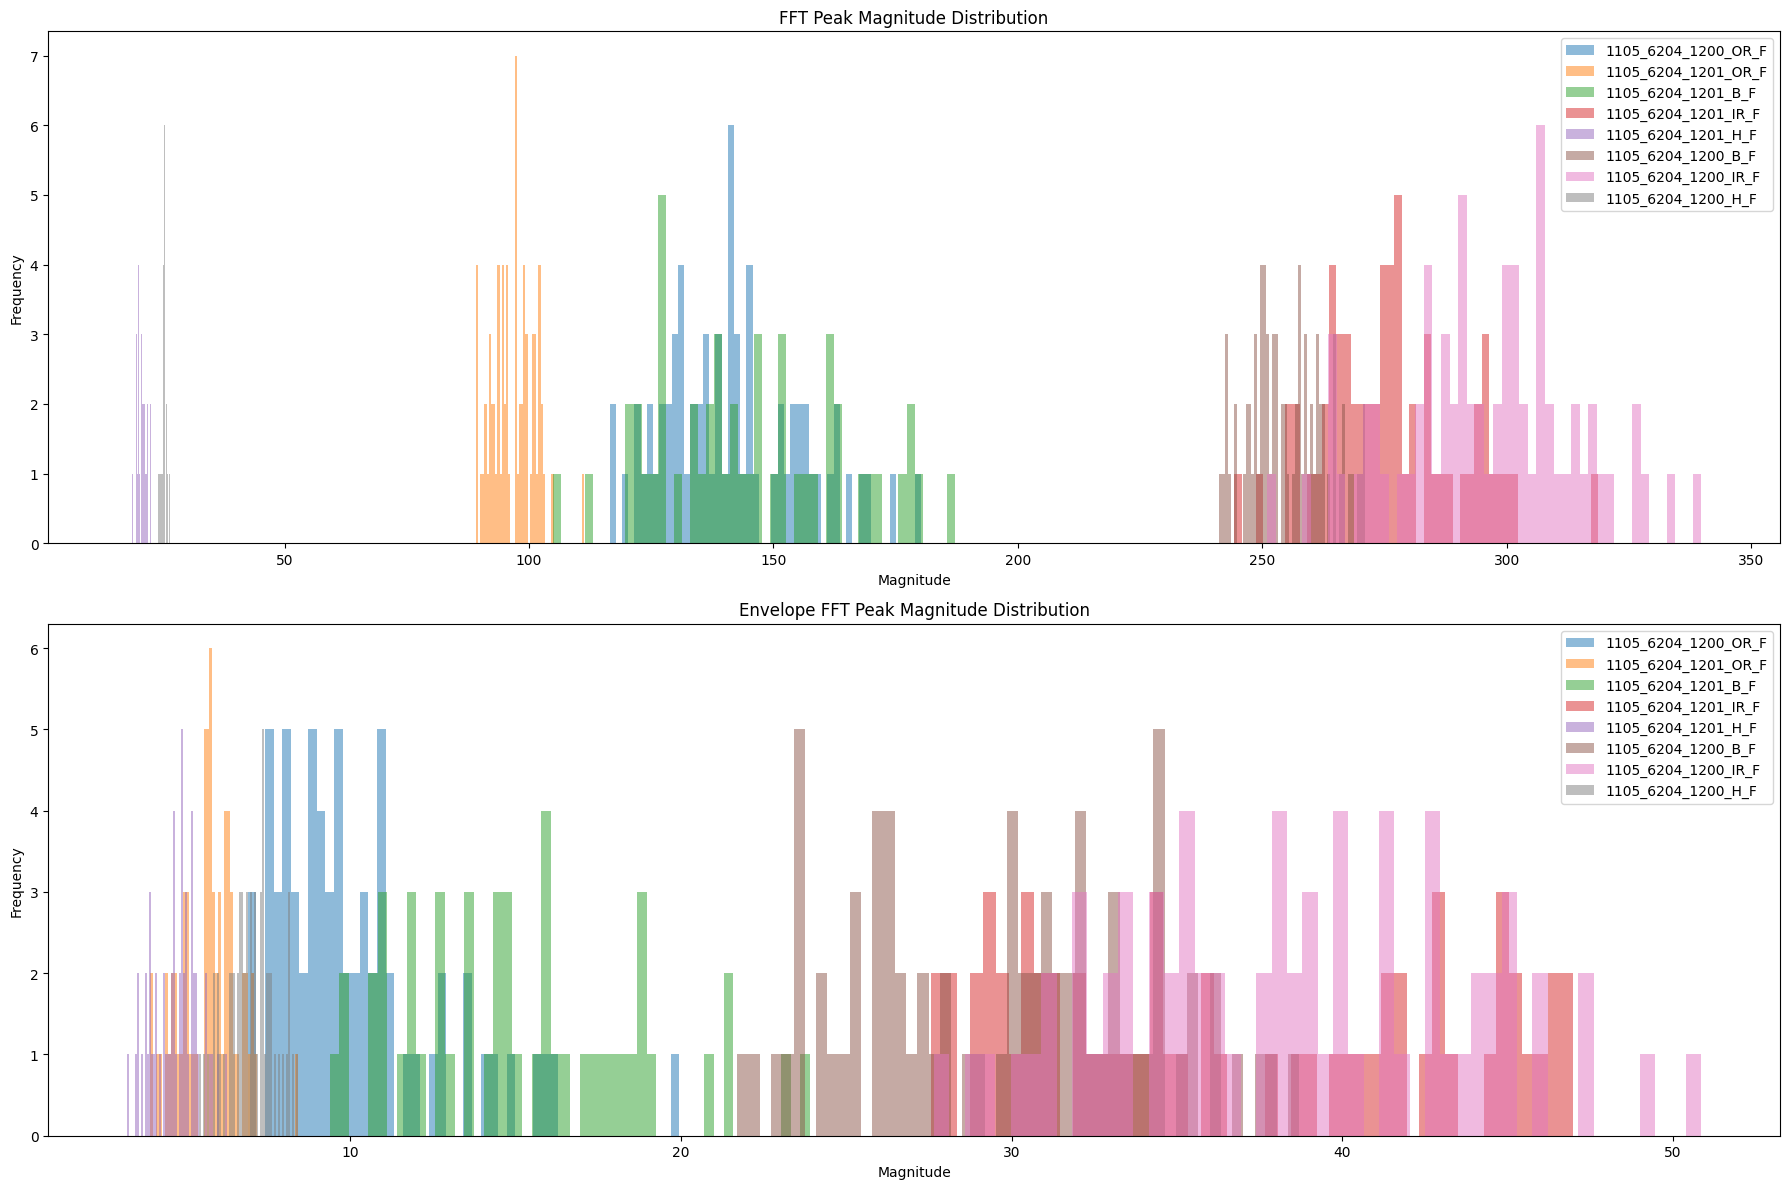

In [4]:
def split_data(file_paths, dir_name, target_axis=None, target_fault_type=None, target_marker=None, target_RPM=None, target_view=None):
    data = []
    parts = dir_name.split('_')
    date = parts[0]
    view = parts[-1]
    fault_type = parts[-2]
    RPM = int(parts[-3])

    # Check if the current directory matches the target criteria
    if (target_view and view != target_view
        ) or (target_RPM and RPM != target_RPM
              ) or (target_fault_type and fault_type != target_fault_type):
        return []

    # Determine the conversion factor
    if int(date) < 1100:
        conversion_factor = conversion_factors.get(date, {}).get(view, 1)
    elif int(date) == 1105:
        conversion_factor = conversion_factors.get(date, {}).get(view, 1).get(fault_type, 1)
    else:
        conversion_factor = conversion_factors.get(date, {}).get(view, 1).get(target_marker, 1)

    for axis, file_path in file_paths.items():
        if target_axis and axis != target_axis:
            continue
        if target_marker == 'A':
            values = pd.read_csv(file_path).iloc[:x_len, 0].values
        elif target_marker == 'B':
            values = pd.read_csv(file_path).iloc[:x_len, 1].values
        # Apply conversion factor
        values = values * conversion_factor
        values -= np.mean(values)  # 평균을 0으로 만듭니다.

        # Sliding window
        window_size = 2048
        overlap = 1024
        for start in range(0, len(values) - window_size + 1, window_size - overlap):
            window = values[start:start + window_size]
            filtered_values = filtfilt(b, a, window)
            envelope = np.abs(hilbert(filtered_values))
            filtered_envelope_values = filtfilt(b, a, envelope)
            
            # FFT and envelope FFT
            fft_result = np.fft.fft(filtered_values)
            envelope_fft_result = np.fft.fft(filtered_envelope_values)
            
            # Compute frequencies
            freqs = np.fft.fftfreq(len(window), 1/fps)
            positive_freqs = freqs[freqs > 0]
            
            # Find peak magnitudes
            fft_peak_magnitude = np.max(np.abs(fft_result[freqs > 0]))
            envelope_fft_peak_magnitude = np.max(np.abs(envelope_fft_result[freqs > 0]))

            data.append([dir_name, axis, fft_peak_magnitude, envelope_fft_peak_magnitude])
    
    return data

# Walk through directories and process files
all_data = []
for root, dirs, files in os.walk(base_dir):
    file_paths = {}
    for file in files:
        if file in ['x.csv', 'y.csv', 'z.csv', 'r.csv']:
            file_paths[file[0]] = os.path.join(root, file)
    
    if len(file_paths) >= 2:  # Ensure at least two files are present
        dir_name = os.path.basename(root)
        data = split_data(file_paths, dir_name, 
                          target_axis=target_axis, 
                          target_fault_type=None,
                          target_marker=target_marker,
                          target_RPM=None,
                          target_view=target_view)
        all_data.extend(data)

# Create DataFrame for the results
columns = ['Directory', 'Axis', 'FFT Peak Magnitude', 'Envelope FFT Peak Magnitude']
df_data = pd.DataFrame(all_data, columns=columns)

# Display the results
print(tabulate(df_data, headers='keys', tablefmt='grid'))

# Visualize the results
plt.figure(figsize=(18, 12))

# Plot FFT Peak Magnitude
plt.subplot(2, 1, 1)
for directory in df_data['Directory'].unique():
    subset = df_data[df_data['Directory'] == directory]
    plt.hist(subset['FFT Peak Magnitude'], bins=50, alpha=0.5, label=directory)
plt.title('FFT Peak Magnitude Distribution')
plt.xlabel('Magnitude')
plt.ylabel('Frequency')
plt.legend()

# Plot Envelope FFT Peak Magnitude
plt.subplot(2, 1, 2)
for directory in df_data['Directory'].unique():
    subset = df_data[df_data['Directory'] == directory]
    plt.hist(subset['Envelope FFT Peak Magnitude'], bins=50, alpha=0.5, label=directory)
plt.title('Envelope FFT Peak Magnitude Distribution')
plt.xlabel('Magnitude')
plt.ylabel('Frequency')
plt.legend()

plt.tight_layout()
plt.show()

### 4. 샘플링하지 않은 각 데이터에 대해 통계값 표로 출력
* 데이터의 구분은 디렉토리 기준이며, 표의 각 행은 디렉토리별 통계값(Peak, RMS 등)을 보여준다.

In [6]:
def calculate_statistics(values):
    peak = np.max(np.abs(values))
    average = np.mean(values)
    rms = np.sqrt(np.mean(values**2))
    crest_factor = peak / rms
    return peak, average, rms, crest_factor

def process_and_calculate(file_paths, dir_name, target_RPM=None, target_fault_type=None, target_axis=None, target_marker=None, target_view=None):
    stats = []
    parts = dir_name.split('_')
    date = parts[0]
    view = parts[-1]
    fault_type = parts[-2]
    RPM = int(parts[-3])
    axis = parts[-1]

    # Check if the current directory matches the target criteria
    if (target_view and view != target_view
        ) or (target_RPM and RPM != target_RPM
              ) or (target_fault_type and fault_type != target_fault_type):
        return []

    # Determine the conversion factor
    if int(date) < 1100:
        conversion_factor = conversion_factors.get(date, {}).get(view, 1)
    elif int(date) == 1105:
        conversion_factor = conversion_factors.get(date, {}).get(view, 1).get(fault_type, 1)
    else:
        conversion_factor = conversion_factors.get(date, {}).get(view, 1).get(target_marker, 1)
    for axis, file_path in file_paths.items():
        if target_axis and axis != target_axis:
            continue
        if target_marker == 'A':
            values = pd.read_csv(file_path).iloc[:x_len, 0].values
        elif target_marker == 'B':
            values = pd.read_csv(file_path).iloc[:x_len, 1].values
        # Apply conversion factor
        values = values * conversion_factor
        values -= np.mean(values)  # 평균을 0으로 만듭니다.
        peak, average, rms, crest_factor = calculate_statistics(values)
        stats.append([dir_name, axis, peak, average, rms, crest_factor])
    
    return stats

# Walk through directories and process files
all_stats = []
for root, dirs, files in os.walk(base_dir):
    file_paths = {}
    for file in files:
        if file in ['x.csv', 'y.csv', 'z.csv', 'r.csv']:
            file_paths[file[0]] = os.path.join(root, file)
    
    if len(file_paths) >= 2:  # Ensure at least two files are present
        dir_name = os.path.basename(root)
        stats = process_and_calculate(file_paths, dir_name,
                                      target_axis=target_axis, 
                                    target_fault_type=None, 
                                    target_marker=target_marker,
                                    target_RPM=None,
                                    target_view=target_view)
        all_stats.extend(stats)

# Create DataFrame for the results
columns = ['Directory', 'Axis', 'Peak', 'Average', 'RMS', 'Crest Factor']
df_stats = pd.DataFrame(all_stats, columns=columns)

# Display the results
print(tabulate(df_stats, headers='keys', tablefmt='grid'))

+----+---------------------+--------+-----------+--------------+-----------+----------------+
|    | Directory           | Axis   |      Peak |      Average |       RMS |   Crest Factor |
+====+=====================+========+===========+==============+===========+================+
|  0 | 1105_6204_1200_OR_F | z      | 0.198321  | -1.19434e-18 | 0.103949  |        1.90786 |
+----+---------------------+--------+-----------+--------------+-----------+----------------+
|  1 | 1105_6204_1201_OR_F | z      | 0.134887  | -1.61884e-18 | 0.0786627 |        1.71476 |
+----+---------------------+--------+-----------+--------------+-----------+----------------+
|  2 | 1105_6204_1201_B_F  | z      | 0.278084  |  8.11292e-18 | 0.146809  |        1.89419 |
+----+---------------------+--------+-----------+--------------+-----------+----------------+
|  3 | 1105_6204_1201_IR_F | z      | 0.399448  | -1.43137e-17 | 0.244753  |        1.63205 |
+----+---------------------+--------+-----------+-----------

### 5, 6. 데이터 샘플링 후 통계값 분석
* 먼저 split_and_calculate 함수에서 데이터를 샘플링한 후 샘플 별 통계값을 리스트에 저장한다.
* 5번의 경우 legend 구분이 각 디렉토리별로 이루어지며, 모든 통계값을 플롯한다.
* 6번의 경우 legend 구분이 fault_type별로 이루어지며, Peak와 RMS만 플롯한다.

In [7]:
def calculate_statistics(values):
    peak = np.max(np.abs(values))
    average = np.mean(values)
    rms = np.sqrt(np.mean(values**2))
    crest_factor = peak / rms
    return peak, average, rms, crest_factor

def split_and_calculate(file_paths, dir_name, target_RPM=None, target_fault_type=None, target_axis=None, target_marker=None, target_view=None):
    stats = []
    parts = dir_name.split('_')
    date = parts[0]
    view = parts[-1]
    fault_type = parts[-2]
    RPM = int(parts[-3])
    axis = parts[-1]

    # Check if the current directory matches the target criteria
    if (target_view and view != target_view
        ) or (target_RPM and RPM != target_RPM
              ) or (target_fault_type and fault_type != target_fault_type):
        return []

    # Determine the conversion factor
    if int(date) < 1100:
        conversion_factor = conversion_factors.get(date, {}).get(view, 1)
    elif int(date) == 1105:
        conversion_factor = conversion_factors.get(date, {}).get(view, 1).get(fault_type, 1)
    else:
        conversion_factor = conversion_factors.get(date, {}).get(view, 1).get(target_marker, 1)
    for axis, file_path in file_paths.items():
        if target_axis and axis != target_axis:
            continue
        if target_marker == 'A':
            values = pd.read_csv(file_path).iloc[:x_len, 0].values
        elif target_marker == 'B':
            values = pd.read_csv(file_path).iloc[:x_len, 1].values
        # Apply conversion factor
        values = values * conversion_factor
        values -= np.mean(values)  # 평균을 0으로 만듭니다.

        # Sliding window
    window_size = 2048
    overlap = 1024
    for start in range(0, len(values) - window_size + 1, window_size - overlap):
        window = values[start:start + window_size]
        peak, average, rms, crest_factor = calculate_statistics(window)
        stats.append([dir_name, axis, peak, average, rms, crest_factor, fault_type])
    
    return stats

# Walk through directories and process files
all_stats = []
for root, dirs, files in os.walk(base_dir):
    file_paths = {}
    for file in files:
        if file in ['x.csv', 'y.csv', 'z.csv', 'r.csv']:
            file_paths[file[0]] = os.path.join(root, file)
    
    if len(file_paths) >= 2:  # Ensure at least two files are present
        dir_name = os.path.basename(root)
        stats = split_and_calculate(file_paths, dir_name,
                                    target_axis=target_axis, 
                                    target_fault_type=target_fault_type,
                                    target_marker=target_marker,
                                    target_RPM=target_RPM,
                                    target_view=target_view)
        all_stats.extend(stats)

# Create DataFrame for the results
columns = ['Directory', 'Axis', 'Peak', 'Average', 'RMS', 'Crest Factor', 'Fault Type']
df_stats = pd.DataFrame(all_stats, columns=columns)

### 5번

+-----+---------------------+--------+-----------+--------------+-----------+----------------+--------------+
|     | Directory           | Axis   |      Peak |      Average |       RMS |   Crest Factor | Fault Type   |
+=====+=====================+========+===========+==============+===========+================+==============+
|   0 | 1105_6204_1200_OR_F | z      | 0.147381  |  0.00904644  | 0.0861639 |        1.71047 | OR           |
+-----+---------------------+--------+-----------+--------------+-----------+----------------+--------------+
|   1 | 1105_6204_1200_OR_F | z      | 0.154574  |  0.00931145  | 0.0860894 |        1.79551 | OR           |
+-----+---------------------+--------+-----------+--------------+-----------+----------------+--------------+
|   2 | 1105_6204_1200_OR_F | z      | 0.154574  |  0.00746534  | 0.0911682 |        1.69549 | OR           |
+-----+---------------------+--------+-----------+--------------+-----------+----------------+--------------+
|   3 | 11

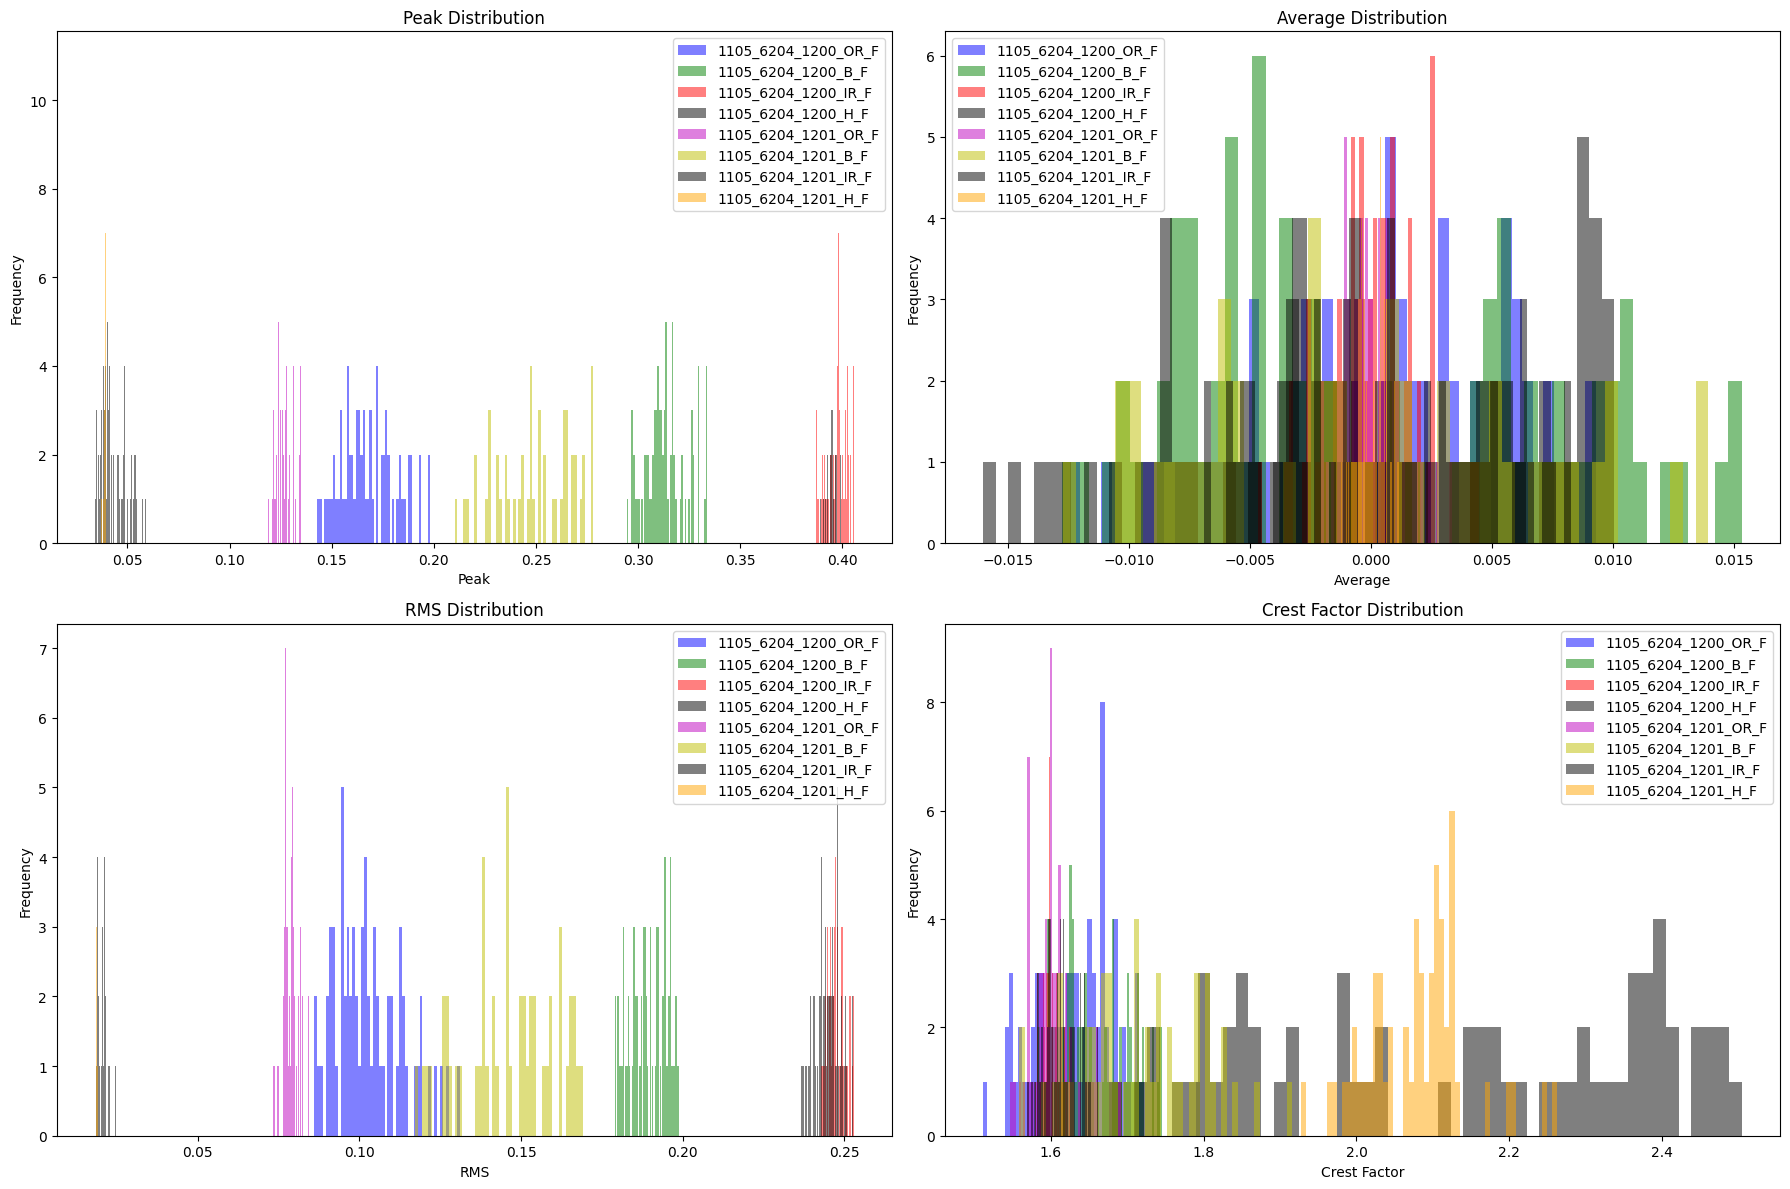

In [27]:
# Walk through directories and process files
all_stats = []
for root, dirs, files in os.walk(base_dir):
    file_paths = {}
    for file in files:
        if file in ['x.csv', 'y.csv', 'z.csv', 'r.csv']:
            file_paths[file[0]] = os.path.join(root, file)
    
    if len(file_paths) >= 2:  # Ensure at least two files are present
        dir_name = os.path.basename(root)
        stats = split_and_calculate(file_paths, dir_name,
                                    target_axis=target_axis, 
                                    target_fault_type=None,
                                    target_marker=target_marker,
                                    target_RPM=None,
                                    target_view=target_view)
        all_stats.extend(stats)

# Create DataFrame for the results
columns = ['Directory', 'Axis', 'Peak', 'Average', 'RMS', 'Crest Factor', 'Fault Type']
df_stats = pd.DataFrame(all_stats, columns=columns)

# Display the results
print(tabulate(df_stats, headers='keys', tablefmt='grid'))

# Define color cycle
colors = cycler('color', ['b', 'g', 'r', 'k', 'm', 'y', 'k', 'orange'])

# Create an iterator from the color cycler object
styles = iter(colors)

# Create a dictionary to store styles for each directory
directory_styles = {}

# Sort directories by RPM and fault type
sorted_directories = sorted(df_stats['Directory'].unique(), key=lambda x: (int(x.split('_')[2]), x.split('_')[1]))

# Visualize the results
plt.figure(figsize=(18, 12))

# Plot Peak
plt.subplot(2, 2, 1)
for directory in sorted_directories:
    subset = df_stats[df_stats['Directory'] == directory]
    style = next(styles)
    directory_styles[directory] = style
    plt.hist(subset['Peak'], bins=50, alpha=0.5, label=directory, **style)
plt.title('Peak Distribution')
plt.xlabel('Peak')
plt.ylabel('Frequency')
plt.legend()

# Plot Average
plt.subplot(2, 2, 2)
for directory in sorted_directories:
    subset = df_stats[df_stats['Directory'] == directory]
    style = directory_styles[directory]
    plt.hist(subset['Average'], bins=50, alpha=0.5, label=directory, **style)
plt.title('Average Distribution')
plt.xlabel('Average')
plt.ylabel('Frequency')
plt.legend()

# Plot RMS
plt.subplot(2, 2, 3)
for directory in sorted_directories:
    subset = df_stats[df_stats['Directory'] == directory]
    style = directory_styles[directory]
    plt.hist(subset['RMS'], bins=50, alpha=0.5, label=directory, **style)
plt.title('RMS Distribution')
plt.xlabel('RMS')
plt.ylabel('Frequency')
plt.legend()

# Plot Crest Factor
plt.subplot(2, 2, 4)
for directory in sorted_directories:
    subset = df_stats[df_stats['Directory'] == directory]
    style = directory_styles[directory]
    plt.hist(subset['Crest Factor'], bins=50, alpha=0.5, label=directory, **style)
plt.title('Crest Factor Distribution')
plt.xlabel('Crest Factor')
plt.ylabel('Frequency')
plt.legend()

plt.tight_layout()
plt.show()

### 6번

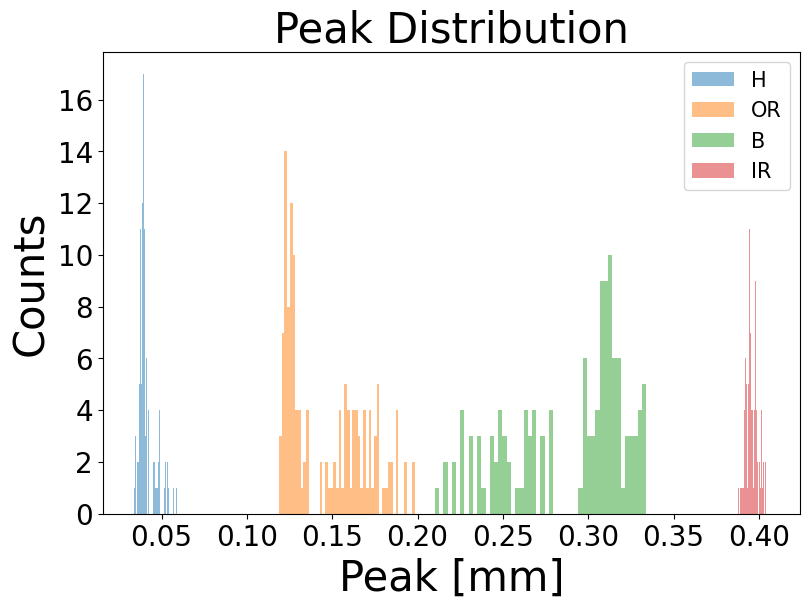

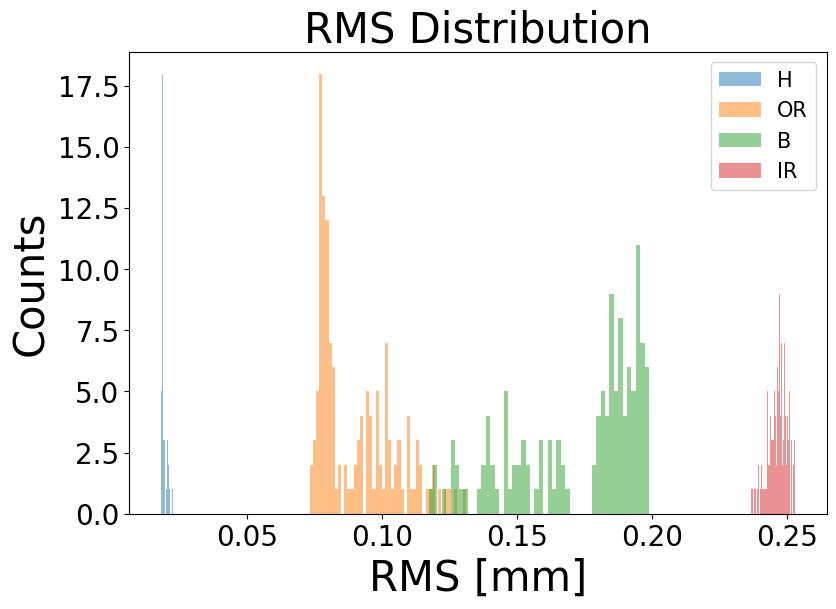

In [26]:
# Walk through directories and process files
all_stats = []
for root, dirs, files in os.walk(base_dir):
    file_paths = {}
    for file in files:
        if file in ['x.csv', 'y.csv', 'z.csv', 'r.csv']:
            file_paths[file[0]] = os.path.join(root, file)
    
    if len(file_paths) >= 2:  # Ensure at least two files are present
        dir_name = os.path.basename(root)
        stats = split_and_calculate(file_paths, dir_name,
                                    target_axis=target_axis, 
                                    target_fault_type=None,
                                    target_marker=target_marker,
                                    target_RPM=None,
                                    target_view=target_view)
        all_stats.extend(stats)

# Create DataFrame for the results
columns = ['Directory', 'Axis', 'Peak', 'Average', 'RMS', 'Crest Factor', 'Fault Type']
df_stats = pd.DataFrame(all_stats, columns=columns)

# 지정된 순서대로 fault_type을 설정합니다.
ordered_fault_types = ['H', 'OR', 'B', 'IR']

# Visualize the results
plt.figure(figsize=(9, 6))

# Plot Peak
for fault_type in ordered_fault_types:
    subset = df_stats[df_stats['Fault Type'] == fault_type]
    plt.hist(subset['Peak'], bins=50, alpha=0.5, label=fault_type)
plt.title('Peak Distribution', size=30)
plt.xlabel('Peak [mm]', size=30)
plt.ylabel('Counts', size=30)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=15)

plt.figure(figsize=(9, 6))
# Plot RMS
for fault_type in ordered_fault_types:
    subset = df_stats[df_stats['Fault Type'] == fault_type]
    plt.hist(subset['RMS'], bins=50, alpha=0.5, label=fault_type)
plt.title('RMS Distribution', size=30)
plt.xlabel('RMS [mm]', size=30)
plt.ylabel('Counts', size=30)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=15)